<a href="https://colab.research.google.com/github/apoorvsingh090/House_Prices_Advanced_Regression_Techniques/blob/main/House_Prices_Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up



---



In [1]:
!wget -O data.zip "https://primeroomlink.herokuapp.com/8176505277972416/house-prices-advanced-regression-techniques.zip"
!7z e data.zip

--2021-03-12 13:14:36--  https://primeroomlink.herokuapp.com/8176505277972416/house-prices-advanced-regression-techniques.zip
Resolving primeroomlink.herokuapp.com (primeroomlink.herokuapp.com)... 52.0.2.156, 3.208.49.102, 52.200.31.227, ...
Connecting to primeroomlink.herokuapp.com (primeroomlink.herokuapp.com)|52.0.2.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203809 (199K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 199.03K   144KB/s    in 1.4s    

2021-03-12 13:14:38 (144 KB/s) - ‘data.zip’ saved [203809/203809]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 203809 bytes (200 KiB)

Extracting archive: data.zip
--
Path = data.zip
Type = zip
Physical Size = 203809

  0%    

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

#Preprocessing


In [3]:
df=pd.read_csv("train.csv")

In [4]:
ord_col = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']  


In [5]:
# Encoding ordinal features
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[ord_col]=enc.fit_transform(df[ord_col].astype(str))

In [6]:
# Standardization of values
from sklearn import preprocessing
ndf = df.select_dtypes(include=np.number)
del ndf['Id']
del ndf['SalePrice']
names = ndf.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(ndf)
ndf = pd.DataFrame(scaled_df, columns=names)
df[ndf.columns] = ndf

In [7]:
# Filling null values and one-hot encoding label features
df2=pd.get_dummies(df,dummy_na=True)#categorical encoding
df3=df2.select_dtypes(include=np.number)#using only numeric columns
df3=df3.fillna(df3.mean())#filling na with mean
col=df3.columns.tolist()
col.remove("SalePrice")
X=df3[col]
y=df3["SalePrice"]
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state=1,test_size=0.20,shuffle=True)



In [8]:
# Finding the more relevant features by mutual information
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores[:80]

OverallQual        0.572862
GrLivArea          0.480171
GarageArea         0.366109
GarageCars         0.365261
TotalBsmtSF        0.364878
                     ...   
ExterCond          0.024593
MiscFeature_nan    0.024497
HouseStyle_SLvl    0.024295
Heating_GasA       0.024099
Fence_MnPrv        0.024044
Name: MI Scores, Length: 80, dtype: float64

In [9]:
finalcol=pd.Series(mi_scores[:80]).index
X=df3[finalcol]
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state=1,test_size=0.20,shuffle=True)


#Models



In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

my_model_1 = XGBRegressor(random_state=0)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.07,0.08],
              'max_depth': [7,8],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7,1],
              'n_estimators': [500]}
xgb_grid = GridSearchCV(my_model_1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)
xgb_grid.fit(train_X, train_y)
xgpredictions=xgb_grid.predict(val_X)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  16 out of  16 | elapsed:   29.3s finished


0.8423402366672501
{'colsample_bytree': 1, 'learning_rate': 0.08, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [12]:
my_model_1 = XGBRegressor(random_state=0)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': .07, #so called `eta` value
              'max_depth': 7,
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}
my_model_1.fit(train_X, train_y)
xgpredictions=my_model_1.predict(val_X)
val_mae1 = mean_absolute_error(xgpredictions, val_y)
print(val_mae1)

[13:16:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
15542.843642979453


In [17]:
import lightgbm as lgb
clf = lgb.LGBMRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.07,0.09],
              'max_depth': [7,11],
              'min_child_weight': [4,1,8],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}
lgb_grid = GridSearchCV(my_model_1,
                        parameters,
                        cv=2,
                        n_jobs = 5,
                        verbose=True)
lgb_grid.fit(train_X, train_y)
lgpredictions=lgb_grid.predict(val_X)
print(lgb_grid.best_score_)
print(lgb_grid.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  24 out of  24 | elapsed:   47.0s finished


0.8694964476946163
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [20]:
clf = lgb.LGBMRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': .07, #so called `eta` value
              'max_depth': 7,
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}
clf.fit(train_X, train_y)
lgpredictions=clf.predict(val_X)
val_mae1 = mean_absolute_error(lgpredictions, val_y)
print(val_mae1)

15777.281684552934


#OtherModels

26417.621434525186


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


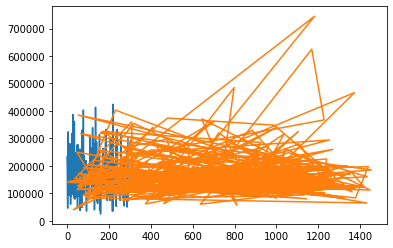

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
mlp.fit(train_X,train_y)
predictions = mlp.predict(val_X)
mae=mean_absolute_error(predictions,val_y)
print(mae)
plt.figure()
plt.plot(predictions)#blue
plt.plot(val_y)#orange
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor  
model2 = DecisionTreeRegressor(random_state=0,)
model2.fit(train_X, train_y)
val_predictions = model2.predict(val_X)
val_mae1 = mean_absolute_error(val_predictions, val_y)
print(val_mae1)


23865.37671232877


In [ ]:
from sklearn.ensemble import RandomForestRegressor 
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print(rf_val_mae)


16055.244417808219


In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(max_iter=2000,tol=5000)
log_reg.fit(train_X,train_y)
log_pred=log_reg.predict(val_X)
reg_mae=mean_absolute_error(log_pred,val_y)
reg_mae

140872.61301369863

In [ ]:
from sklearn.linear_model import LinearRegression
reg=LogisticRegression(max_iter=500)
reg.fit(train_X,train_y)
pred=reg.predict(val_X)
reg_mae=mean_absolute_error(pred,val_y)
reg_mae

28346.83904109589

#Predicting on test data


In [ ]:
test=pd.read_csv("test.csv")

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
test[ord_col]=enc.fit_transform(test[ord_col].astype(str))
testdf = test.select_dtypes(include=np.number)
del testdf['Id']
names = testdf.columns
scaled_df = scaler.fit_transform(testdf)
testdf = pd.DataFrame(scaled_df, columns=names)
test[testdf.columns] = testdf
testdf2=pd.get_dummies(test,dummy_na=True)#categorical encoding
testdf3=testdf2.select_dtypes(include=np.number)#using only numeric columns
testdf3=testdf3.fillna(testdf3.mean())#filling na with mean
col1=[]
for x in finalcol:
  if x in testdf3.columns:
    col1.append(x)
test_X = testdf3[col1]
test_preds =my_model_1.predict(test_X)
output = pd.DataFrame({'Id': test.Id,'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)